In [ ]:
try:
    from imutils import paths 
except:
    !pip install imutils 
    from imutils import paths 

In [1]:
from tensorflow import keras 
import tensorflow as tf 
from tensorflow.keras import models 
import os 
#from imutils import paths 
import matplotlib.pyplot as plt 
import numpy as np 

import shutil
import cv2
import random
from dataclasses import dataclass 
from tqdm import tqdm
import tempfile
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, GlobalMaxPooling2D, \
                                                GlobalAveragePooling2D, BatchNormalization, Flatten, ReLU
import tensorflow_addons as tfa  

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
BATCH_SIZE = 128

In [ ]:
class DataLoader: 
    """
        Class, will be useful for creating the BYOL dataset or dataset for the DownStream task 
            like classification or segmentation.
        Methods:
            __download_data(scope: private)
            __normalize(scope: private)
            __preprocess_img(scope: private)
            __reshape_downstream_img(scope: private)
             __get_valdata(scope: private)
            get_byol_dataset(scope: public)
            get_downstream_data(scope: public)
        
        Property:
            dname(dtype: str)        : dataset name(supports cifar10, cifar100).
            byol_augmentor(type      : ByolAugmentor): byol augmentor instance/object.
            nval(type: int)          : Number of validation data needed, this will be created by splitting the testing
                                       data.
            resize_shape(dtype: int) : Resize shape, bcoz pretrained models, might have a different required shape.
            normalize(dtype: bool)   : bool value, whether to normalize the data or not. 
    """
    
    def __init__(self, dname="cifar10", byol_augmentor=None, nval=5000,
                                             resize_shape=32, normalize=True, downstream_data=False): 
        assert (byol_augmentor != None or downstream_data), 'Need a BYOL Augment object'
        assert dname in ["cifar10", 'cifar100'], "dname should be either cifar10 or cifar100"
        assert nval <= 10_000, "ValueError: nval value should be <= 10_000"
        
        __train_data, __test_data = self.__download_data(dname)
        self.__train_X, self.__train_y = __train_data
        self.__train_X, self.__train_y = self.__train_X, self.__train_y
      #  self.__train_X, self.__train_y = self.__train_X[: 100], self.__train_y[: 100]
        self.__dtest_X, self.__dtest_y = __test_data 
        self.class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                                           'dog', 'frog', 'horse', 'sheep', 'truck']
        self.byol_augmentor = byol_augmentor
        self.__get_valdata(nval)
        self.resize_shape = resize_shape
        
        self.__normalize() if normalize else None
        self.min_obj_cov_value = 0.7
        self.color_jitter_value = 0.1
        
    def __len__(self): 
        return self.__train_X.shape[0] + self.__dtest_X.shape[0]
    
    def __repr__(self): 
        return f"Training Samples: {self.__train_X.shape[0]}, Testing Samples: {self.__dtest_X.shape[0]}"
    
    def __download_data(self, dname):
        """
            Downloads the data from the tensorflow website using the tensorflw.keras.load_data() method.
            Params:
                dname(type: Str): dataset name, it just supports two dataset cifar10 or cifar100
            Return(type(np.ndarray, np.ndarray))
                returns the training data and testing data
        """
        if dname == "cifar10": 
            train_data, test_data = tf.keras.datasets.cifar10.load_data()
        if dname == "cifar100": 
            train_data, test_data = tf.keras.datasets.cifar100.load_data()
            
        return train_data, test_data
    
    def __normalize(self): 
        """
            this method, will used to normalize the inputs.
        """
        self.__train_X = self.__train_X / 255.0
        self.__dtest_X = self.__dtest_X / 255.0
    
    def __preprocess_img(self, image): 
        """
            this method, will be used by the get_byol_dataset methos, which does a convertion of 
            numpy data to tensorflow data.
            Params:
                image(type: np.ndarray): image data.
            Returns(type; (np.ndarray, np.ndarray))
                returns the two different augmented views of same image.
        """
        try: 
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.resize(image, (self.resize_shape, self.resize_shape))
            view1 = self.byol_augmentor.augment(image, self.resize_shape)
            view2 = self.byol_augmentor.augment(image, self.resize_shape)
            
            return (view1, view2)
        
        except Exception as err:
            return err
    
    def get_byol_dataset(self, batch_size, dataset_type="train"):
        """
            this method, will gives the byol dataset, which is nothing but a tf.data.Dataset object.
            Params:
                batch_size(dtype: int)    : Batch Size.
                dataset_type(dtype: str)  : which type of dataset needed, (train, test or val)
                
            return(type: tf.data.Dataset)
                returns the tf.data.Dataset for intended dataset_type, by preprocessing and converting 
                the np data.
        """
        try:
            if dataset_type == "train":
                tensorflow_data = tf.data.Dataset.from_tensor_slices((self.__train_X))
                tensorflow_data = (
                tensorflow_data
                    .map(self.__preprocess_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                    .shuffle(1024)
                    .batch(batch_size, drop_remainder=True)
                    .prefetch(tf.data.experimental.AUTOTUNE)
                )
                return tensorflow_data  
            
            if dataset_type == "test":
                tensorflow_data = tf.data.Dataset.from_tensor_slices((self.__test_X))
                tensorflow_data = (
                tensorflow_data
                    .map(self.__preprocess_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                    .shuffle(1024)
                    .batch(batch_size, drop_remainder=True)
                    .prefetch(tf.data.experimental.AUTOTUNE)
                )
                return tensorflow_data  
            
            if dataset_type == "val":
                tensorflow_data = tf.data.Dataset.from_tensor_slices((self.__val_X))
                tensorflow_data = (
                tensorflow_data
                    .map(self.__preprocess_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                    .shuffle(1024)
                    .batch(batch_size, drop_remainder=True)
                    .prefetch(tf.data.experimental.AUTOTUNE)
                )
                return tensorflow_data  
        
        except Exception as err:
            return err
    
    def get_downstream_data(self): 
        """
            this method returns the dataset for the downstream task.
        """
        return (self.__train_X, self.__train_y)#, (self.__val_X, self.__val_y), (self.__test_X, self.__test_y)
    
    def __get_valdata(self, nval):
        """
            this method is used to create a validation data by randomly sampling from the testing data.
            Params:
                nval(dtype: Int); Number of validation data needed, rest of test_X.shape[0] - nval, will be 
                                  testing data size.
            returns(type; np.ndarray, np.ndarray):
                returns the testing and validation dataset.
        """
        try: 
            ind_arr = np.arange(10_000)
            val_inds = np.random.choice(ind_arr, nval, replace=False)
            test_inds = [i for i in ind_arr if not i in val_inds]

            self.__test_X, self.__test_y = self.__dtest_X[test_inds], self.__dtest_y[test_inds]
            self.__val_X, self.__val_y = self.__dtest_X[val_inds], self.__dtest_y[val_inds]
            
        except Exception as err:
            raise err    
            
    def __reshape_downstream_img(self, img, y):
        """
            this method is used to reshape the image, and this method will be used by the get_downstream_tf_dataset
                method.
            Params:
                img(type: tf.Tensor): Image Tensor.
                y(dtype: int): Corresponding label of the image.
            Return(type: tf.Tensor, int)
                returns reshaped image and its label
        """
        img = tf.image.resize(img, (self.resize_shape, self.resize_shape))
        return img, y
        
    def get_downstream_tf_dataset(self, batch_size, dataset_type="train"): 
        """
             this method, will gives the downstream dataset, which is of type tf.data.Dataset object.
            Params:
                batch_size(dtype: int)    : Batch Size.
                dataset_type(dtype: str)  : which type of dataset needed, (train, test or val)
                
            return(type: tf.data.Dataset)
                returns the tf.data.Dataset for intended dataset_type, by preprocessing and converting 
                the np data.
        """
        assert dataset_type in ["train", "test", "val"], "Given dataset type is not valid"
        try:
            if dataset_type == "train":
                tensorflow_data = tf.data.Dataset.from_tensor_slices((self.__train_X, self.__train_y))
                tensorflow_data = (
                tensorflow_data
                    .map(self.__reshape_downstream_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                    .shuffle(1024)
                    .batch(batch_size, drop_remainder=True)
                    .prefetch(tf.data.experimental.AUTOTUNE)
                )
                return tensorflow_data  
            
            if dataset_type == "test":
                tensorflow_data = tf.data.Dataset.from_tensor_slices((self.__test_X, self.__test_X))
                tensorflow_data = (
                tensorflow_data
                    .map(self.__reshape_downstream_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                    .shuffle(1024)
                    .batch(batch_size, drop_remainder=True)
                    .prefetch(tf.data.experimental.AUTOTUNE)
                )
                return tensorflow_data  
            
            if dataset_type == "val":
                tensorflow_data = tf.data.Dataset.from_tensor_slices((self.__val_X, self.__val_y))
                tensorflow_data = (
                tensorflow_data
                    .map(self.__reshape_downstream_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                    .shuffle(1024)
                    .batch(batch_size, drop_remainder=True)
                    .prefetch(tf.data.experimental.AUTOTUNE)
                )
                return tensorflow_data  
        
        except Exception as err:
            return err

In [2]:
trained_model = keras.models.load_model("barlow-twin")

In [ ]:
trained_model.summary()

In [10]:
train_ds = get_downstream_tf_dataset(BATCH_SIZE, "train")
val_ds = get_downstream_tf_dataset(BATCH_SIZE, "valid")
test_ds = get_downstream_tf_dataset(BATCH_SIZE, "test")

In [11]:
base_encoder = keras.models.Model(trained_model.input, trained_model.layers[-2].output)
base_encoder.trainable = False

In [ ]:
base_encoder.summary()

In [13]:
def get_linear_model(): 
    input_ = Input(shape=(32, 32, 3))
    x = base_encoder(input_)
    out = Dense(10, activation='softmax')(x)
    return keras.models.Model(input_, out)

In [14]:
model_lin = get_linear_model()

In [15]:
model_lin.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 model (Functional)          (None, 512)               11187328  
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
Total params: 11,192,458
Trainable params: 5,130
Non-trainable params: 11,187,328
_________________________________________________________________


In [20]:
model_lin.compile(loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"],
                  optimizer="adam"
                 )

In [21]:
history = model_lin.fit(train_ds, validation_data=test_ds, epochs=20)

Epoch 1/20
391/391 [==============================] - 7s 15ms/step - loss: 1.3481 - accuracy: 0.5698 - val_loss: 1.4045 - val_accuracy: 0.5508
Epoch 2/20
391/391 [==============================] - 5s 13ms/step - loss: 1.3263 - accuracy: 0.5724 - val_loss: 1.4965 - val_accuracy: 0.5289
Epoch 3/20
391/391 [==============================] - 6s 14ms/step - loss: 1.3286 - accuracy: 0.5742 - val_loss: 1.3994 - val_accuracy: 0.5544
Epoch 4/20
391/391 [==============================] - 5s 13ms/step - loss: 1.3258 - accuracy: 0.5731 - val_loss: 1.4018 - val_accuracy: 0.5513
Epoch 5/20
391/391 [==============================] - 5s 13ms/step - loss: 1.3298 - accuracy: 0.5725 - val_loss: 1.4742 - val_accuracy: 0.5468
Epoch 6/20
391/391 [==============================] - 5s 13ms/step - loss: 1.3266 - accuracy: 0.5747 - val_loss: 1.4528 - val_accuracy: 0.5470
Epoch 7/20
391/391 [==============================] - 5s 13ms/step - loss: 1.3375 - accuracy: 0.5721 - val_loss: 1.3932 - val_accuracy: 0.5582

In [30]:
import matplotlib.pyplot as plt 

def plot_acc(history): 
    """
        this function, used to plot the Train data Accuracy and Val data Accuracy.
        Params:
            history(type: tf.History): history object, returned by the keras model .fit() method.
        Return(type: None)
    """
    with plt.xkcd():
        plt.plot(history.history["accuracy"], label="train_acc")
        plt.plot(history.history["val_accuracy"], label="val_acc")
        plt.title("Training and val Accuracy")
        plt.xlabel("Epoch #")
        plt.ylabel("Accuracy")
        plt.legend(loc="lower left")
        
        plt.show()
        
def plot_loss(history):  
    """
        this function, used to plot the Train data Loss and Val data Loss.
        Params:
            history(type: tf.History): history object, returned by the keras model .fit() method.
        Return(type: None)
    """
    with plt.xkcd():
        plt.plot(history.history["loss"], label="train_loss")
        plt.plot(history.history["val_loss"], label="val_loss")

        plt.title("Training Loss and val loss")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss")
        plt.legend(loc="lower left")
        
        plt.show()
    

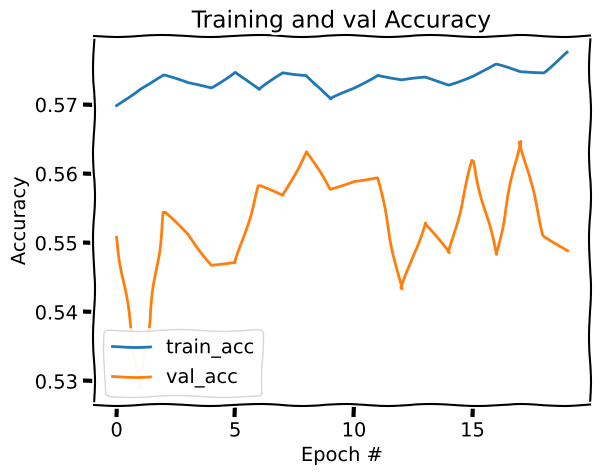

In [31]:
plot_acc(history)

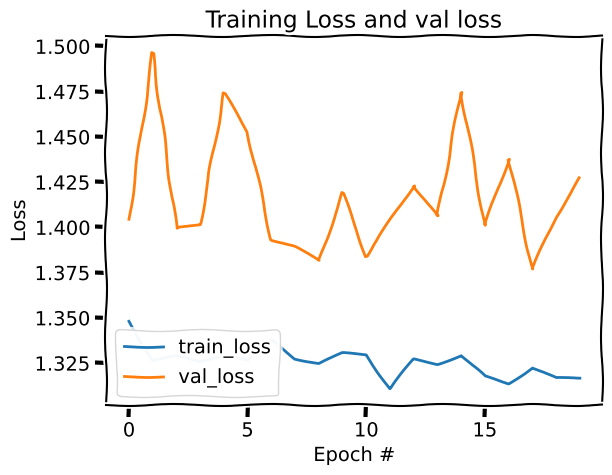

In [32]:
plot_loss(history)